In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, input_dim=784, num_classes=10, latent_dim=20):
        super(CVAE, self).__init__()
        
        # --- ENCODER ---
        # Input = Image (784) + Label (10)
        self.fc1 = nn.Linear(input_dim + num_classes, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        
        # --- DECODER ---
        # Input = Latent (20) + Label (10)
        self.fc3 = nn.Linear(latent_dim + num_classes, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x, c):
        # Concatenate image (x) and label (c)
        inputs = torch.cat([x, c], dim=1)
        h1 = F.relu(self.fc1(inputs))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        # Standard VAE reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # Concatenate latent vector (z) and label (c)
        inputs = torch.cat([z, c], dim=1)
        h3 = F.relu(self.fc3(inputs))
        return torch.sigmoid(self.fc4(h3)) # Sigmoid to output pixel values 0-1

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [2]:
def loss_function(recon_x, x, mu, logvar):
    # Binary Cross Entropy for reconstruction
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [90]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 100
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def one_hot(labels, num_classes):
    # FIXED: Ensure the lookup table is on the same device as the labels
    return torch.eye(num_classes, device=labels.device)[labels]

# Training
model.train()
for epoch in range(20):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        # Create one-hot labels (now safe)
        c = one_hot(labels, 10) 
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data, c)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Using device: mps
Epoch: 0 Average loss: 155.9591
Epoch: 1 Average loss: 116.8340
Epoch: 2 Average loss: 110.8549
Epoch: 3 Average loss: 107.9314
Epoch: 4 Average loss: 106.1240
Epoch: 5 Average loss: 104.8959
Epoch: 6 Average loss: 103.9374
Epoch: 7 Average loss: 103.1646
Epoch: 8 Average loss: 102.6157
Epoch: 9 Average loss: 102.1334
Epoch: 10 Average loss: 101.6558
Epoch: 11 Average loss: 101.3305
Epoch: 12 Average loss: 101.0671
Epoch: 13 Average loss: 100.7913
Epoch: 14 Average loss: 100.4695
Epoch: 15 Average loss: 100.2911
Epoch: 16 Average loss: 100.0909
Epoch: 17 Average loss: 99.8660
Epoch: 18 Average loss: 99.6946
Epoch: 19 Average loss: 99.5959


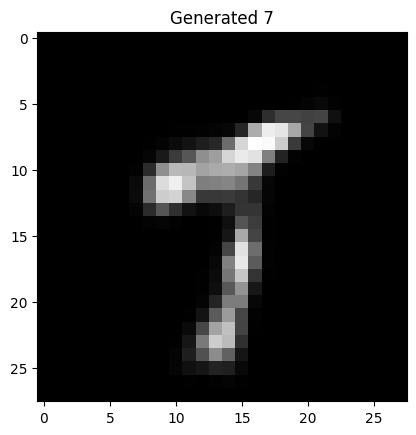

In [145]:
import matplotlib.pyplot as plt

def generate_digit(digit_to_generate):
    model.eval()
    with torch.no_grad():
        # 1. Sample random noise (latent vector)
        z = torch.randn(1, 20).to(device)
        
        # 2. Create the label condition (e.g., generate a "5")
        c = torch.tensor([digit_to_generate]).to(device)
        c = one_hot(c, 10)
        
        # 3. Decode
        generated_img = model.decode(z, c)
        
        # 4. Display
        plt.imshow(generated_img.cpu().view(28, 28), cmap='gray')
        plt.title(f"Generated {digit_to_generate}")
        plt.show()

# Example usage:
generate_digit(7)